Steps to Perform for MFCC Transfer Learning
Step 1: Load the files and convert to mfcc

In [3]:
n_mfcc = 128
n_mfcc_width = 432
window_size = 10
audio_len = 90
data_dir = 'audio-train-new'
n_samples = 118

In [1]:
import librosa as lp
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import shutil

def run_preprocess(root, length, split):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
#             print(directory)
            mfcc_data = []
            npy_file = directory + '_' + 'mfcc' + '_' + str(512) + '_' + length + '_' + split + '.npy'
            if os.path.isfile(os.path.join(subdir, directory, npy_file)):
                continue

            if not os.path.isdir(os.path.join(subdir, directory, "split", split)):
                subprocess.call(["./preprocess", os.path.join(subdir, directory), length, split])

            file_path = os.path.join(subdir, directory, "split", split, "wav")
            for filename in os.listdir(file_path):
                y, sr = lp.load(os.path.join(file_path, filename))
                mfcc = lp.feature.mfcc(y = y, sr = 16000, n_mfcc = 128)
#                 print(mfcc.shape)
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, n_mfcc_width)), mode='constant')
                if mfcc.shape != (n_mfcc, n_mfcc_width):
                    mfcc = mfcc[:, :n_mfcc_width]
#                 print(mfcc.shape)
                mfcc_data.append(mfcc)

            np.save(os.path.join(subdir, directory, npy_file), np.asarray(mfcc_data))
#             print(np.asarray(mfcc_data).shape)
            shutil.rmtree(os.path.join(subdir, directory, "split"), ignore_errors = True)
        break

In [3]:
import shutil

def rename_npy(root, length, split):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            npy_file = directory + '_' + length + '_' + split + '.npy'
            new_npy_file = directory + '_' + 'mfcc' + '_' + str(512) + '_' + length + '_' + split + '.npy'
            if os.path.isfile(os.path.join(subdir, directory, npy_file)):
                shutil.move(os.path.join(subdir, directory, npy_file), os.path.join(subdir, directory, new_npy_file))
        break

In [4]:
def load_features(root, length, split):
    mfcc_data = np.zeros((0, n_mfcc, n_mfcc_width))
    mfcc_label = []
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            if len(directory.split(".")) != 2:
                continue
            npy_file = directory + '_' + 'mfcc' + '_' + str(512) + '_' + length + '_' + split + '.npy'
            mfcc = np.load(os.path.join(subdir, directory, npy_file))
            if mfcc.size == 0:
                continue
            mfcc_data = np.concatenate((mfcc_data, mfcc[:, :n_mfcc, :]))
            mfcc_label += mfcc.shape[0] * [directory.split('.')[0]]
        break
    return mfcc_data, mfcc_label

In [5]:
def cleanup_split(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            shutil.rmtree(os.path.join(subdir, directory, "split"), ignore_errors = True)
        break

In [6]:
import glob

def cleanup_merged(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            for f in glob.glob(os.path.join(subdir, directory, "*_merged*.*")):
                os.remove(f)
        break

def cleanup_npy(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            for f in glob.glob(os.path.join(subdir, directory, "*.npy")):
                os.remove(f)
        break

In [7]:
def rename_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            shutil.move(os.path.join(subdir, directory), os.path.join(subdir, directory.split("_")[0]))
        break

def remove_extra_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            name_o = directory.split(".") 
            if len(name_o) == 2 and int(name_o[1]) > 10:
                shutil.rmtree(os.path.join(subdir, directory))
        break
    
def distribute_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            if len(directory.split(".")) != 1:
                continue
            for d_subdir, d_dirs, d_files in os.walk(os.path.join(root, directory)):
                for i, sample in enumerate(d_files):
                    os.makedirs(os.path.join(subdir, directory + "." + str(i + 1)))
                    shutil.move(os.path.join(subdir, directory, sample), \
                                os.path.join(subdir, directory + "." + str(i + 1), sample))
                break
        remove_extra_samples(root)
        break

In [5]:
cleanup_split(data_dir)
# cleanup_npy(data_dir)
# rename_samples(data_dir)
# distribute_samples(data_dir)
run_preprocess(data_dir, str(audio_len), str(window_size))

NameError: name 'cleanup_split' is not defined

In [50]:
X, y = load_features(data_dir, str(audio_len), str(window_size))
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)

In [52]:
import keras
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

l_enc = LabelEncoder()
l_enc.fit(y_train)
y_train_enc = l_enc.transform(y_train)
y_train_norm = np_utils.to_categorical(y_train_enc)

l_enc.fit(y_test)
y_test_enc = l_enc.transform(y_test)
y_test_norm = np_utils.to_categorical(y_test_enc)

In [53]:
# del X, y, y_train_enc, y_test_enc, y_train, y_test
X_train = X_train[:, :64, :, :]
X_test = X_test[:, :64, :, :]

In [54]:
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=(n_mfcc, n_mfcc_width, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(n_mfcc/2, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(len(y_test_norm[0])))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
ctr = 1

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='mfcc_model.png', show_shapes=True)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 63, 431, 32)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 215, 32)       0         
_________________________________________________________________
activation_4 (Activation)    (None, 31, 215, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 215, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 215, 32)       4128      
_________________________________________________________________
activation_5 (Activation)    (None, 31, 215, 32)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 107, 32)       0         
__________

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 63, 431, 32)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 215, 32)       0         
_________________________________________________________________
activation_4 (Activation)    (None, 31, 215, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 215, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 215, 32)       4128      
_________________________________________________________________
activation_5 (Activation)    (None, 31, 215, 32)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 107, 32)       0         
__________

In [55]:
train_result = model.fit(np.array(X_train), y_train_norm,
          batch_size=16,
          epochs=30,
          verbose=1,
          shuffle = True,
         validation_data=(np.array(X_test), y_test_norm))

Train on 1584 samples, validate on 679 samples
Epoch 1/30
1584/1584 [==============================] - 42s 26ms/step - loss: 15.5530 - acc: 0.0303 - val_loss: 16.0469 - val_acc: 0.0044
Epoch 2/30
1584/1584 [==============================] - 43s 27ms/step - loss: 15.6504 - acc: 0.0278 - val_loss: 15.7145 - val_acc: 0.0250
Epoch 3/30
1584/1584 [==============================] - 44s 28ms/step - loss: 15.4579 - acc: 0.0398 - val_loss: 15.6433 - val_acc: 0.0295
Epoch 4/30
1584/1584 [==============================] - 44s 28ms/step - loss: 15.3600 - acc: 0.0448 - val_loss: 15.4196 - val_acc: 0.0236
Epoch 5/30
1584/1584 [==============================] - 41s 26ms/step - loss: 15.2257 - acc: 0.0524 - val_loss: 15.6433 - val_acc: 0.0295
Epoch 6/30
1584/1584 [==============================] - 41s 26ms/step - loss: 15.1407 - acc: 0.0511 - val_loss: 15.4176 - val_acc: 0.0339
Epoch 7/30
1584/1584 [==============================] - 44s 28ms/step - loss: 15.0625 - acc: 0.0568 - val_loss: 15.2872 - val

In [56]:
model.save_weights('mfcc_model_weights_' + str(audio_len) + '_' + str(window_size) + '-' + str(n_mfcc) + '_' + str(ctr) + '.h5')
ctr += 1

In [22]:
print(train_result.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


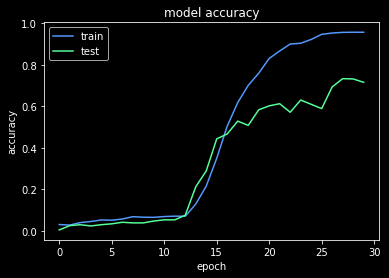

In [57]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.plot(train_result.history['acc'], color="#5599FF")
plt.plot(train_result.history['val_acc'], color="#55FF99")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()